# Deep Learning for Computer Vision:  HW 3


## Computer Science: COMS W 4995 007


### Due: October 17, 2019

#### Problem

You are given two dimensional input from three separate classes. Your task is to implement a multi-layer perceptron (MLP) 3-class classifier with multiple hidden layers and a regularization on the weights. For the activiation function of the hidden units use ReLU or leaky ReLU. For the predictions use softmax on a linear output layer as we did in class. Your loss layer should compute $-\log P(y = i \,|{\bf x})$ where $i$ is the correct label according to the training data.

a) Implement each layer type (hidden, output, and loss) as separate python classes, each with methods for initialization, forward propagation, and backpropagation.

b) Implement a MLP as its own class, with separate methods for initialization, adding a layer, forward propagation, backpropagation, training and prediction. 

c) Let the layer dimensions be parameters passed when the network is created.

d) Let the number of training epochs, the mini-batch size, and the regularization parameter be parameters that are passed when training the network.

e) Build and run your network using your own constructs. The code for doing this might look like:

In [ ]:
NN = MLP()
NN.add_layer('Hidden', dim_in=2, dim_out=16)
NN.add_layer('Hidden', dim_in=16, dim_out=16)
NN.add_layer('Hidden', dim_in=16, dim_out=16)
NN.add_layer('Output', dim_in=16, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.0)
plot_loss(loss)
plot_decision_regions(NN)

f) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the three different labels. 

g) Repeat varying the number of hidden units (3, 8, 16), the number of hidden layers (1 and 3), and the regularization value (0 and some other value of your choosing).

h) Now replace your ReLU activation function with a softplus function and repeat.

Grading: a-g=90%, h=10%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.  

#### YOUR CODE MUST BE YOUR OWN.
_______________________________________________________________



Let's start by importing some libraries.

In [262]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Let's make up our 2D data for our three classes.

In [263]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = random.randint(0,1)
    x2 = random.randint(0,1)
    if x1 == 1 and x2 == 0:
        y = 0
    elif x1 == 0 and x2 == 1:
        y = 0
    elif x1 == 0 and x2 == 0:
        y = 1
    else:
        y = 2
    x1 = 1.0 * x1 + 0.20 * np.random.normal()
    x2 = 1.0 * x2 + 0.20 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
    
for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,2] = 1

for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 0.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = -0.75 + 0.20 * np.random.normal()
    data.iloc[k,2] = 2
    
# Now let's normalize this data.
data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()
        
data.head()

,x1,x2,y
0,-1.740040,0.794200,0.0
1,0.658542,0.459189,2.0
2,0.787934,1.116039,1.0
3,-1.702754,-0.747712,1.0
4,-0.915379,0.819017,0.0


Let's message this data into a numpy format.

In [264]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [265]:
# Sloppy function for plotting our data
def plot_data(X, y_predict):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    indices_0 = [k for k in range(0, X.shape[0]) if y_predict[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y_predict[k] == 2]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2,1], marker='o', linestyle='', ms=5, label='2')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Tricky 3 Class Classification')
    plt.show()

Now let's plot it.

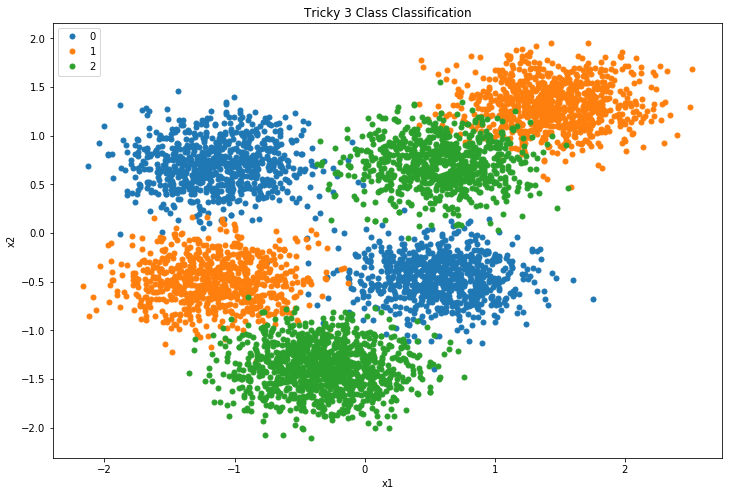

In [266]:
plot_data(X, y)

Now build your network. Good luck! 😉 

In [267]:
# Take input and apply W matirx + constant to get output
# Find hidden layer backpropogation

# Dim in is the number of dimensions coming in and dim out is the output,
# depending on the number of units in the hidden layer and the next layer
class Hidden:
    # Should be initialized randomly anad then updated during training
    def __init__(self, input_dim, output_dim):
        self.w_matrix = np.random.random((input_dim, output_dim))
        self.c_matrix = np.random.random((output_dim, 1))
        self.partial_deriv_wrt_w = np.zeros((input_dim, output_dim))
        self.partial_deriv_wrt_c = np.zeros((output_dim, 1))
        self.u_2 = None
        self.input_matrix = None
        
    # Input matrix should be input_dim by batch size
    def forward_prop(self, input_matrix):
        self.input_matrix = input_matrix
        w_T = np.transpose(self.w_matrix)
        u_1 = np.matmul(w_T, input_matrix)
        self.u_2 = u_1 + self.c_matrix
        # Apply relu regularization
        h = np.zeros((self.u_2.shape[0], self.u_2.shape[1]))
        for i in range(h.shape[0]):
            for j in range(h.shape[1]):
                h[i, j] = max(0, self.u_2[i, j])
        # Input matrix for the next layer
        return h
    
    # have this function take in the upstream gradient and output that times the local gradient?
    # This shouldn't be the partial derivative of z every time, should be for partial_deriv_z for the last hidden layer
    # but partial_deriv of h of the next layer for a middle hidden layer
    # more like previous partial deriv?
    def back_prop(self, curr_partial_deriv, next_w):
        # next_w, whatever the matrix is for the next layer?
        # multiply the partial derivative from the previous values with the next W matrix (see notes)
        # u_2 is the input to the current layer
        next_partial_deriv = np.matmul(next_w, curr_partial_deriv)
        # dimension of nodes
        dim_1 = self.u_2.shape[0]
        # number of batches
        dim_2 = self.u_2.shape[1]
        f_u_2 = np.zeros((dim_1, dim_2))
        for i in range(dim_1):
            for j in range(dim_2):
                if self.u_2[i, j] <=0:
                    f_u_2[i, j] = 0
                else: 
                    f_u_2[i, j] = 1
        self.partial_deriv_wrt_c = np.multiply(f_u_2, next_partial_deriv)
        w_sum = np.zeros((self.w_matrix.shape[0], self.w_matrix.shape[1]))
       
        #Input matrix is the data x (2 by batches)
        input_matrix = np.array(self.input_matrix).T
        batch_size = input_matrix.shape[0]
        for i in range(batch_size):
            x_term = np.array([input_matrix[i]]).T
            c_term = self.partial_deriv_wrt_c[:,i].reshape(1, self.w_matrix.shape[1])
            w_sum = w_sum + np.matmul(x_term, c_term)
        self.partial_deriv_wrt_w = w_sum/batch_size
        return next_partial_deriv

In [268]:
class Output:
    # Dim-in is the number of units in the previous layer and dim-out is the number of classes 
    def __init__(self, input_dim, output_dim):
        self.w_o_matrix  = np.random.random((input_dim, output_dim))
        # Shuld be dimout by 1
        self.b_matrix = np.random.random((output_dim, 1))
        self.partial_deriv_wrt_b = np.zeros((output_dim, 1))
        self.partial_deriv_wrt_w_o = np.zeros((input_dim, output_dim))
        self.input_matrix = None
    
    # Make input_matirx a class parameter?
    def forward_prop(self, input_matrix):
        self.input_matrix = input_matrix
        w_o_T = np.transpose(self.w_o_matrix)
        u_3 = np.matmul(w_o_T, input_matrix)
        z = u_3 + self.b_matrix
        # Input into the loss layer, should be number of classes by batch size
        return z
    
    # Output from the layer before
    def back_prop(self, partial_deriv_wrt_z):
        self.partial_deriv_wrt_b = partial_deriv_wrt_z
        w_o_sum = np.zeros((self.w_o_matrix.shape[0], self.w_o_matrix.shape[1]))
        # input should be input_dim by batch_size
        input_matrix = np.array(self.input_matrix).T
        batch_size = input_matrix.shape[0]
        for i in range(batch_size):
            h_term = np.array([input_matrix[i]]).T
            z_term = partial_deriv_wrt_z[:,i].reshape(1, self.w_o_matrix.shape[1])
            w_o_sum = w_o_sum + np.matmul(h_term, z_term)
        self.partial_deriv_wrt_w_o = w_o_sum/batch_size

In [269]:
# Loss should include regularization
class Loss:
    #  Need weight matrices from all the classes for regularization
    def __init__(self, dim_out):
        # loss is number of classes by 1
        self.loss = np.zeros((dim_out, 1))
        self.reg_term = None
        self.partial_deriv_wrt_z = None
        # y is 1 by batch size
    
    # Give the sum of the norms into this function and would be dependent on the number of layers
    def forward_prop(self, z, y, norm_sum, reg_term):
        # z should be number of classes by batch size, average across the batches
        # Go across the columns
        self.reg_term = reg_term
        loss = np.zeros((z.shape[0], z.shape[1]))
        for i in range(z.shape[1]):
            true_y = y[0, i]
            # Get the values for a particular batch
            values = z[:,i]
            # Find exponential of every term
            exps = [np.exp(val) for val in values]
            # Sum and find the log
            log_loss = np.log10(np.sum(exps))
            # Go across rows
            for j in range(z.shape[0]):
                if true_y == j:
                    # For the correct class, add negative of the z value
                    loss[j, i] = -1 * z[j, i] + log_loss
                else:
                    loss[j, i] = log_loss
        # Average across the batch
        self.loss = np.sum(loss, axis=1)/z.shape[1]
        # Add regularization terms to loss
        self.loss = self.loss + self.reg_term/2 * (norm_sum)
    
    # Get partial derivative WRT to z
    # What about the regularization term???
    def back_prop(self, z, y):
        # Should be number of classes by batch
        self.partial_deriv_wrt_z = np.zeros((z.shape[0], z.shape[1]))
        # Go across column
        for i in range(z.shape[1]):
            true_y = y[0, i]
            # Get the values for a particular batch
            values = z[:,i]
            # Find exponential of every term
            exp = [np.exp(val) for val in values]
            exp_sum = np.sum(exp)
            for j in range(z.shape[0]):
                if true_y == j:
                    self.partial_deriv_wrt_z[j, i] = -1 + exp[j]/exp_sum
                else:
                    self.partial_deriv_wrt_z[j, i] = exp[j]/exp_sum

In [270]:
class mlp:
    def __init__(self):
        self.hidden_layers = []
        self.output_layer = None
        self.loss_layer = None
    
    # Should initialize the layers
    def add_layer(self, layer_type, dim_in, dim_out):
        if layer_type == 'Hidden':
            h_layer = Hidden(dim_in, dim_out)
            self.hidden_layers.append(h_layer)
        elif layer_type == 'Output':
            self.output_layer = Output(dim_in, dim_out)
        elif layer_type == 'Loss':
            self.loss_layer = Loss(dim_out)
        else:
            raise ValueError('Layer type not regonized')    
        
    def forward_prop(self, input_data, y, reg_term, train=True):
        norm_sum = 0
        for h in self.hidden_layers:
            input_data = h.forward_prop(input_data)
            norm_sum = np.linalg.norm(h.w_matrix) + norm_sum
        z = self.output_layer.forward_prop(input_data)
        norm_sum = norm_sum + np.linalg.norm(self.output_layer.w_o_matrix)
        if train:
            self.loss_layer.forward_prop(z, y, norm_sum, reg_term)
            return z
        else:
            print('Here you should predict')
        
    def back_prop(self, z, y):
        self.loss_layer.back_prop(z, y)
        self.output_layer.back_prop(self.loss_layer.partial_deriv_wrt_z)
        next_w = self.output_layer.w_o_matrix
        curr_error = self.loss_layer.partial_deriv_wrt_z
        for i in range(len(self.hidden_layers), 0, -1):
            curr_error = self.hidden_layers[i-1].back_prop(curr_error, next_w)
            next_w = self.hidden_layers[i-1].w_matrix     
    
    def train(X_data, y_data, epochs, b_size, reg_term):
        epochs = 100
        b_size = 10
        num_groups = epochs/b_size
        for i in range(epochs):
            
            for j in range(num_groups):
                
        data = X.T[:,0:10]
        true_y = y.T[:, 0:10]
        reg_term = 0.01
        for i in range(epochs):
            forward_propr()
        # batch size of 10
        # 200 data points
        # 20 patches
        # Update weights 
                
    #def predict():

In [271]:
NN = mlp()
NN.add_layer('Hidden', dim_in=2, dim_out=4)
NN.add_layer('Hidden', dim_in=4, dim_out=5)
NN.add_layer('Hidden', dim_in=5, dim_out=4)
NN.add_layer('Output', dim_in=4, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)


z = NN.forward_prop(data, true_y, reg_term)
NN.back_prop(z, true_y)